In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import mlflow
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error

import logging
logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

import warnings
warnings.filterwarnings("ignore")

# Auswahl der Daten und Datenvorarbeitung

In [5]:
# get data from git repository
#csv_url = 'https://raw.githubusercontent.com/Jas53/Data_Exploration_Project/main/data/WorldHappinessReport/2019.csv?token=GHSAT0AAAAAABRTCQJSXY2MLH74DIOZQA2UYQOB2QQ'
#df = pd.read_csv(csv_url)
df = pd.read_csv('./data/WorldHappinessReport/2019.csv')
# set new index for DataFrame
df.set_index('Country or region', inplace = True)
df.head()

,Overall rank,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
Country or region,,,,,,,,
Finland,1,7.769,1.340,1.587,0.986,0.596,0.153,0.393
Denmark,2,7.600,1.383,1.573,0.996,0.592,0.252,0.410
Norway,3,7.554,1.488,1.582,1.028,0.603,0.271,0.341
Iceland,4,7.494,1.380,1.624,1.026,0.591,0.354,0.118
Netherlands,5,7.488,1.396,1.522,0.999,0.557,0.322,0.298


In [6]:
# Check if there are doubled countries
df.index.value_counts()

Finland                1
Venezuela              1
Jordan                 1
Benin                  1
Congo (Brazzaville)    1
                      ..
Latvia                 1
South Korea            1
Estonia                1
Jamaica                1
South Sudan            1
Name: Country or region, Length: 156, dtype: int64

=> Man sieht, dass jedes Land nur einmal aufgeführt ist.

In [7]:
# define target feature and create feature list
target_feature = 'Score'
features = df.columns.to_list()
features = [feature for feature in features if feature not in target_feature]

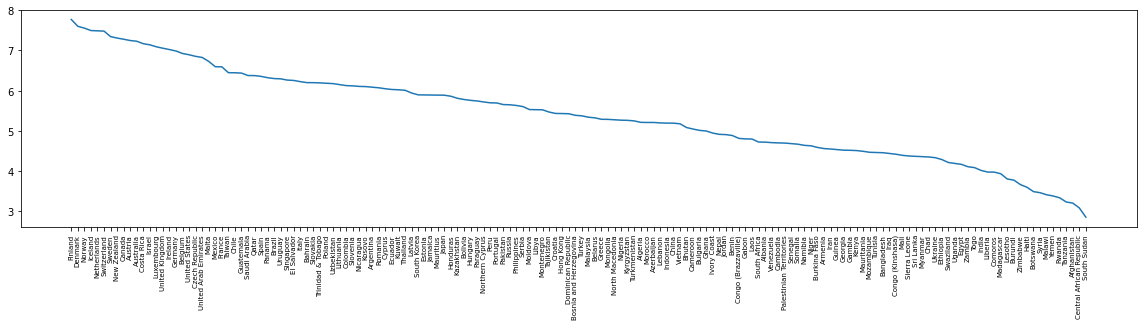

In [8]:
fig, ax = plt.subplots(1, 1, figsize = (20, 4))
ax.plot(df[target_feature])
ax.tick_params(axis = 'x', rotation = 90, labelsize = 7)

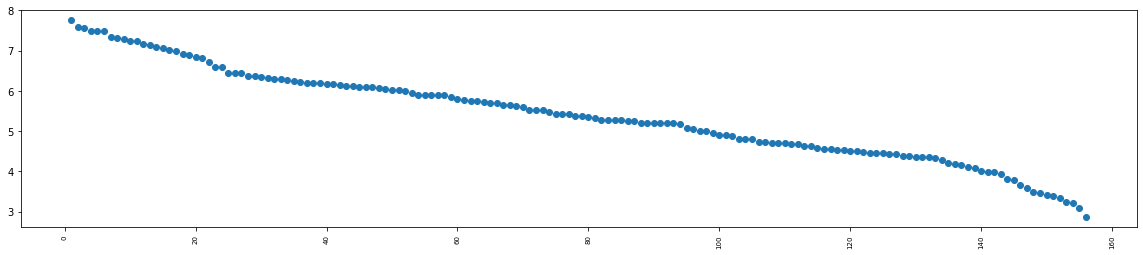

In [9]:
fig, ax = plt.subplots(1, 1, figsize = (20, 4))
ax.scatter(df['Overall rank'], df[target_feature])
ax.tick_params(axis = 'x', rotation = 90, labelsize = 7)

# Split Data

In [10]:
# Split all data in training and testing data (Size 90 / 10)
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target_feature], test_size = 0.1, random_state = 1)

# Split training data into training and validating data (Size 75 / 25)
X_train, X_val, y_train, y_val = train_test_split(X_train[features], y_train, test_size = 0.25)

Damit haben wir ~67% (105 Records) Trainingsdaten zum trainieren des Modells, ~23% (35 Records) Validierungsdaten, um die Hyperparameter zu tunen und das Modell zu optimieren und ~10% (16 Records) Testdaten für die Demo des Modells.

# Train model

In [54]:
def calc_metrics(actual_data: pd.Series, prediction_data: np.ndarray):
    """
    calculate the different metrics (mean squared error, root mean squared error, mean absolute error 
        and mean absolute percentage error) to evaluate the model accuracy.
    
    Params:
        actual_data (Series): the actual imported data
        prediction_data (ndarray): the from the model predicted data
    
    Returns:
        mse (Float): the calculated mean squared error value
        rmse (Float): the calculated root mean squared error value
        mae (Float): the claclulated mean absolute error value
        mape (FLoat): the calculated mean absolute percentage error value
    """
    mse = mean_squared_error(actual_data, prediction_data)
    rmse = mean_squared_error(actual_data, prediction_data, squared = False)
    mae = mean_absolute_error(actual_data, prediction_data)
    mape = np.mean(np.abs((actual_data - prediction_data) / actual_data)) * 100
    
    print('########## METRICS ##########')
    print('MSE:\t%s\nRMSE:\t%s\nMAE:\t%s\nMAPE:\t%s' % (mse, rmse, mae, mape))
    
    return mse, rmse, mae, mape

In [27]:
def train(alpha: float = 1.0, l1_ratio: float = 0.5):
    with mlflow.start_run():
        # create model
        model = ElasticNet(alpha = alpha, l1_ratio = l1_ratio)
        # fit model
        model.fit(X_train, y_train)
        # predict 
        pred = model.predict(X_val)
        
        print('########## MODEL ##########')
        print('alpha:\t%s\nl1_ratio:\t%s' % (alpha, l1_ratio))
        mse, rmse, mae, mape = calc_metrics(y_val, pred)
        
        mlflow.log_param("alpha", alpha)
        mlflow.log_param("l1_ratio", l1_ratio)
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("mape", mape)

        mlflow.sklearn.log_model(model, "model")

In [55]:
alpha_values = [1.0, 2.0, 3.0, 4.0, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 6.0]
l1_ratio_values = [0.0, 0.5, 1.0]

best model @ alpha = 4.7 and l1_ratio = 1.0

In [56]:
for alpha_value in alpha_values:
    for l1_ratio_value in l1_ratio_values:
        train(alpha = alpha_value, l1_ratio = l1_ratio_value)

########## MODEL ##########
alpha:	1.0
l1_ratio:	0.0
########## METRICS ##########
MSE:	0.023875387646867776
RMSE:	0.15451662579433895
MAE:	0.1240261948647674
MAPE:	2.7093351926302405
########## MODEL ##########
alpha:	1.0
l1_ratio:	0.5
########## METRICS ##########
MSE:	0.02328327420161014
RMSE:	0.1525885782147869
MAE:	0.1200381884426686
MAPE:	2.6430935056629465
########## MODEL ##########
alpha:	1.0
l1_ratio:	1.0
########## METRICS ##########
MSE:	0.022749173337279608
RMSE:	0.15082829090485514
MAE:	0.11592677080658369
MAPE:	2.573885359880215
########## MODEL ##########
alpha:	2.0
l1_ratio:	0.0
########## METRICS ##########
MSE:	0.02390305186075097
RMSE:	0.15460611844539326
MAE:	0.1238853454059388
MAPE:	2.707399933871763
########## MODEL ##########
alpha:	2.0
l1_ratio:	0.5
########## METRICS ##########
MSE:	0.0227280706147235
RMSE:	0.1507583185589555
MAE:	0.1157240274233365
MAPE:	2.5704725483231736
########## MODEL ##########
alpha:	2.0
l1_ratio:	1.0
########## METRICS ##########
MSE: